# Long Short Term Memory for Cloud Learning for Hourly Predictions

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.optimizers import Adam

### Importing Dataset

In [2]:
file_path = 'final-dataset.csv'
data = pd.read_csv(file_path)

### Preprocessing Dataset

In [3]:
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

#### Creating Lag Features for Temporal Patterns

In [4]:
# Feature Engineering: Adding lag features
data['Lag1'] = data['PM2.5'].shift(1)
data['Lag2'] = data['PM2.5'].shift(2)
data = data.dropna()

In [5]:
features = data[['Year', 'Month', 'Day', 'Hour', 'Lag1', 'Lag2']]
target = data['PM2.5']

#### Scaling Features and Target

In [6]:
# Scaling the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

#### Train Test Split

In [7]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

In [8]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### Building LSTM NN Model for Hourly Predictions

In [9]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

#### Training Model

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/100
66/66 [==============================] - 8s 27ms/step - loss: 0.0160 - val_loss: 0.0045
Epoch 2/100
66/66 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 3/100
66/66 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 4/100
66/66 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/100
66/66 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 6/100
66/66 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 7/100
66/66 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 8/100
66/66 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/100
66/66 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/100
66/66 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0018
E

#### Making Predictions

In [11]:
# Make predictions for the test set
y_pred = model.predict(X_test)

17/17 [==============================] - 1s 2ms/step


In [12]:
# Inverse scaling to get actual values
y_test_actual = scaler_target.inverse_transform(y_test)
y_pred_actual = scaler_target.inverse_transform(y_pred)

### Evaluating Model Performance

In [13]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

In [14]:
# Print metrics
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 163.97573004781208
RMSE: 12.805300857372
MAE: 6.970769499634141
R2: 0.9051034265360054


### Visual Plot for Actual and Predicted Data Points

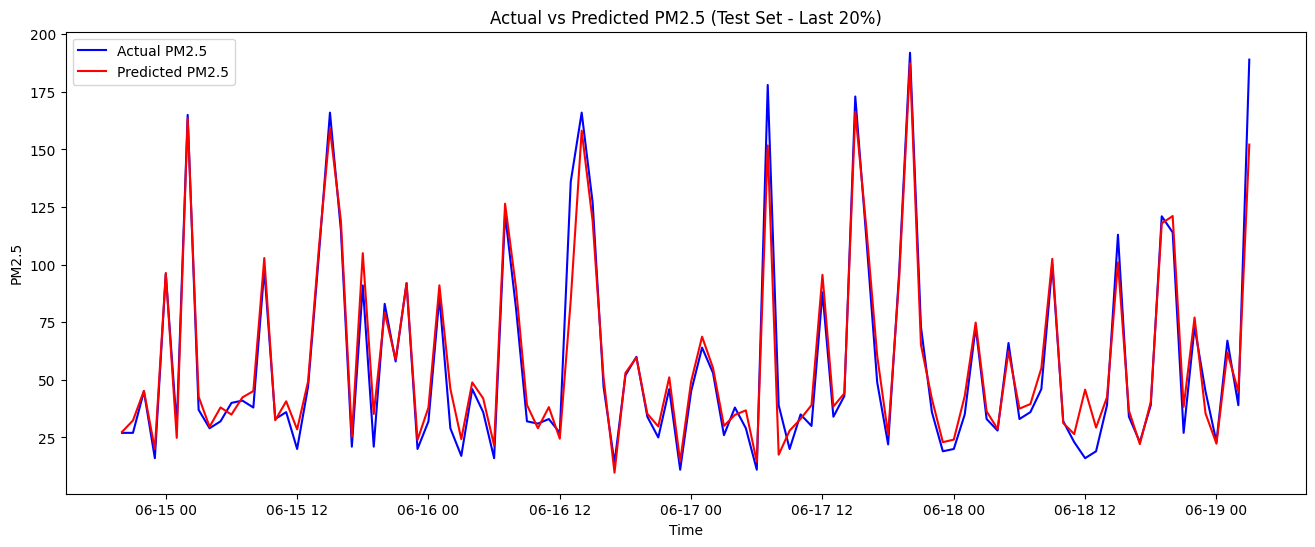

In [18]:
# Calculate the number of points to include (20% of the total points)
n_points = len(y_test_actual)
n_points_20_percent = int(n_points * 0.2)

# Select only the last 20% of the data
x_indices = data.index[-n_points_20_percent:]
y_test_actual_20_percent = y_test_actual[-n_points_20_percent:]
y_pred_actual_20_percent = y_pred_actual[-n_points_20_percent:]

# Plot actual vs predicted values for the last 20% of the test set
plt.figure(figsize=(16, 6))
plt.plot(x_indices, y_test_actual_20_percent, color='blue', label='Actual PM2.5')
plt.plot(x_indices, y_pred_actual_20_percent, color='red', label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Test Set - Last 20%)')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()